In [163]:
import re
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, when, desc, row_number, monotonically_increasing_id
from pyspark.ml.feature import RegexTokenizer,StopWordsRemover
from pyspark.sql.window import Window
from textblob import TextBlob
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt

In [164]:
spark =SparkSession.builder.appName('SparkProject').getOrCreate() 

In [165]:
df = spark.read.json("CompleteData.json")

In [166]:
df = df.dropDuplicates(['id'])
df = df.filter("rawContent != ''")

In [167]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def remove_number(string):
    string = re.sub('([0-9]+)', '', string)
    return string

def remove_users(string):
    string = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', string) 
    string = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', string) 
    return string

<>:17: DeprecationWarning: invalid escape sequence '\s'
<>:17: DeprecationWarning: invalid escape sequence '\s'
/var/folders/hb/h9nbyj456fs5m9jgzhd_g7y40000gn/T/ipykernel_1265/2418726465.py:17: DeprecationWarning: invalid escape sequence '\s'
  string = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', string)


In [168]:
remove_emoji=udf(remove_emoji)
remove_users=udf(remove_users)
remove_number=udf(remove_number)

df=df.withColumn('rawContent', remove_emoji(df['rawContent']))
df=df.withColumn('rawContent', remove_users(df['rawContent']))
df=df.withColumn('rawContent', remove_number(df['rawContent']))
df = df.withColumn('rawContent', F.regexp_replace('rawContent', r'http\S+', ''))
df = df.withColumn('rawContent', F.regexp_replace('rawContent', '@\w+', ''))
df = df.withColumn('rawContent', F.regexp_replace('rawContent', '#', ''))
df = df.withColumn('rawContent', F.regexp_replace('rawContent', 'RT', ''))
df = df.withColumn('rawContent', F.regexp_replace('rawContent', ':', ''))
df = df.withColumn('rawContent', F.regexp_replace('rawContent', '\n', ''))
df = df.withColumn('rawContent', F.regexp_replace('rawContent', '|', ''))
df = df.withColumn('rawContent', F.regexp_replace('rawContent', '[^\sa-zA-Z0-9]', ''))
df = df.withColumn("rawContent",F.lower('rawContent'))
df = df.withColumn("rawContent",F.rtrim('rawContent'))

df = df.withColumn('Tweet_No', row_number().over(Window.orderBy(monotonically_increasing_id())) - 1)


<>:9: DeprecationWarning: invalid escape sequence '\w'
<>:15: DeprecationWarning: invalid escape sequence '\s'
<>:9: DeprecationWarning: invalid escape sequence '\w'
<>:15: DeprecationWarning: invalid escape sequence '\s'
/var/folders/hb/h9nbyj456fs5m9jgzhd_g7y40000gn/T/ipykernel_1265/3161452617.py:9: DeprecationWarning: invalid escape sequence '\w'
  df = df.withColumn('rawContent', F.regexp_replace('rawContent', '@\w+', ''))
/var/folders/hb/h9nbyj456fs5m9jgzhd_g7y40000gn/T/ipykernel_1265/3161452617.py:15: DeprecationWarning: invalid escape sequence '\s'
  df = df.withColumn('rawContent', F.regexp_replace('rawContent', '[^\sa-zA-Z0-9]', ''))


In [169]:
#Tokenizing the Raw Content
tokenizer = RegexTokenizer().setPattern("[\\W_]+").setMinTokenLength(3).setInputCol("rawContent").setOutputCol("tokens")
df = tokenizer.transform(df)

In [170]:
#Removing Stopwords
nltk.download('stopwords')
stopwordList = stopwords.words('english')
remover = StopWordsRemover(stopWords=stopwordList)
remover.setInputCol("tokens")
remover.setOutputCol("filtered")
df = remover.transform(df)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/phanithdsv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [171]:
#Lemmentization
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatization(row):
    row = [lemmatizer.lemmatize(word,'v') for word in row]
    return row

lemmatization = udf(lemmatization)
df=df.withColumn('tokens', lemmatization(df['filtered']))


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/phanithdsv/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [172]:
#Extracting Sentiments from the tweet
sentiment_polarity = udf(lambda x: TextBlob(x).sentiment[0])
spark.udf.register("sentiment_polarity", sentiment_polarity)
df = df.withColumn('sentiment_polarity',sentiment_polarity('rawContent').cast('double'))

sentiment_subjectivity = udf(lambda x: TextBlob(x).sentiment[1])
spark.udf.register("sentiment_subjectivity", sentiment_subjectivity)
df = df.withColumn('sentiment_subjectivity',sentiment_subjectivity('rawContent').cast('double'))


22/12/01 20:27:33 WARN SimpleFunctionRegistry: The function sentiment_polarity replaced a previously registered function.
22/12/01 20:27:34 WARN SimpleFunctionRegistry: The function sentiment_subjectivity replaced a previously registered function.


In [173]:
# Extracting raw content values
rawContents = df.select("rawContent").rdd.flatMap(lambda x: x).collect()

# Extracting tokenized filtered content values
filteredContents = df.select("filtered").rdd.flatMap(lambda x: x).collect()

In [174]:
# Function to create the eta for topic modelling
def create_eta(topics, dictionary):
    eta = np.full(shape=(len(topics), len(dictionary)), fill_value=1) 
    for word, topic in topics.items():
        keyindex = [index for index,term in dictionary.items() if term==word] 
        if (len(keyindex)>0): 
            eta[topic,keyindex[0]] = 1e7 
    eta = np.divide(eta, eta.sum(axis=0)) 
    return eta

In [175]:
# Function to create and run the guided lda model
def test_eta(eta, dictionary):
    corp = filteredContents
    np.random.seed(42) 
    bow = [dictionary.doc2bow(line) for line in corp] 
    with (np.errstate(divide='ignore')):  
        model = LdaModel(
            corpus=bow, id2word=dictionary, num_topics=eta.shape[0],
            random_state=42, chunksize=100, eta=eta,
            eval_every=-1, update_every=1,
            passes=150, alpha='auto', per_word_topics=True)
    return model

In [176]:
topic_labelling = {
    'cost': 0,'value': 0,'worth': 0,'valuation': 0,'premium': 0,'rate': 0,'overprice': 0,'cheap': 0,'discount': 0,'inflation': 0,'pay': 0,'amount': 0,'expense': 0,'expensive': 0,'dollar': 0,'money': 0,'costly': 0,'prise': 0,'priceless': 0,'undervalue': 0,'overvalue': 0,'revaluation': 0,'pennyworth': 0,'economy': 0,'underrate': 0,'underprice': 0,'profit': 0,'estimate':0 ,'fees':0 ,'marginal':0 ,'cash':0 ,'pocket':0 ,'capital':0 ,'dime':0 ,'markup':0 ,'haggle':0 ,'wholesale':0 ,'quotation':0 ,'stipend':0 ,'afford':0 ,'savings':0 ,'save':0,'range':1 ,'anxiety':1 ,'far':1 ,'distance':1 ,'long':1 ,'area':1 ,'long-range':1 ,'short-range':1 ,'travel':1 ,'near':1 ,'mileage':1 ,'afar':1 ,'farther':1 ,'reach':1 ,'remote':1 ,'short':1 ,'stretch':1 ,'haul':1 ,'distant':1 ,'commute':1 ,'extended-range':1,'fuel':2 ,'zero':2 ,'emission':2 ,'das':2 ,'diesel':2 ,'refuel':2 ,'coal':2 ,'oil ':2 ,'charcoal':2 ,'biogas':2 ,'fossil':2 ,'electric':2 ,'ev':2,'eco':3 ,'eco-friendly':3 ,'carbon':3 ,'footprint':3 ,'pollution':3 ,'sustainable':3 ,'renewal':3 ,'power':3 ,'plug':3 ,'green':3 ,'environment':3 ,'earth':3 ,'friendly':3 ,'carbon':3 ,'footprint':3,'batttery':4 ,'cell':4 ,'life':4 ,'charge':4 ,'charger':4 ,'voltage':4 ,'elctrolyte':4 ,'surcharge':4 ,'lithium-ion':4 ,'lithium':4 ,'ion':4 ,'battery cost':4 ,'battery life':4 ,'Fuel cell':4 ,'killowatt':4 ,'hour':4 ,'killowatt-hour':4 ,'regenerative':4 ,'regenerative-braking':4, 'infra':5 ,'infrastructure':5 ,'stations':5 ,'charging':5 ,'plug':5 ,'chademo':5 ,'fast charging':5 ,'supercharger':5 ,'framework':5 ,'structure':5 ,'groundwork':5 ,'support':5
}
dictionary = corpora.Dictionary(filteredContents)
eta = create_eta(topic_labelling, dictionary)
lda_model = test_eta(eta, dictionary)

In [178]:
def format_topics_sentences(lda_model, corpus, rawContents):
    sent_topics_df = pd.DataFrame()
    for i, row_list in enumerate(lda_model[corpus]):
        row = row_list[0] if lda_model.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(rawContents)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

corpus = [dictionary.doc2bow(words) for words in filteredContents]
df_topic_sents_keywords = format_topics_sentences(lda_model, corpus, rawContents)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Tweet_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Tweet']

/var/folders/hb/h9nbyj456fs5m9jgzhd_g7y40000gn/T/ipykernel_1265/1586861331.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


In [179]:
df_dominant_topic.head(10)

,Tweet_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Tweet
0,0,18,0.2395,"electricvehicles, evs, get, much, way, starts,...",tune in now to listen to hdts jack roberts on ...
1,1,7,0.1989,"week, webinar, register, ive, collect, dumpthe...",happy webinar week dont miss this thursdays we...
2,2,107,0.3326,"group, work, sign, exciting, tomorrow, interes...",tomorrow february st at gmt and i will be p...
3,3,18,0.2395,"electricvehicles, evs, get, much, way, starts,...",more ev chargers coming to gov electricvehicl...
4,4,59,0.3049,"deliveries, pickup, lordstown, chairman, secon...",news electricvehicles foxconn lordstownenduran...
5,5,59,0.2775,"deliveries, pickup, lordstown, chairman, secon...",news electricvehicles lordstown will begin del...
6,6,112,0.2459,"global, prices, recent, audi, oil, rise, less,...",electricvehicles currently make up less than ...
7,7,118,0.2624,"sustainability, biden, teslas, please, lets, l...",petitions rarely have an effect but it sure f...
8,8,18,0.2687,"electricvehicles, evs, get, much, way, starts,...",okinawa ebikes ebike electricvehicles electr...
9,9,38,0.3529,"tesla, renewableenergy, renewables, climatecha...",mercedesbenz eqc sedan imagined with vision e...


In [180]:
# Calculating Sentiment for each Tweet

dominant_topic=spark.createDataFrame(df_dominant_topic)
join = df.join(dominant_topic, dominant_topic.Tweet_No == df.Tweet_No, 'left').select(dominant_topic.Tweet_No, dominant_topic.Dominant_Topic,dominant_topic.Tweet,df.sentiment_polarity,df.sentiment_subjectivity)

/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [181]:
# Adding new Sentiment column to our data
df3 = join.withColumn("Sentiment", when(join.sentiment_polarity > 0, 1).when(join.sentiment_polarity < 0, -1).otherwise(0))

In [182]:
df3 .show()

22/12/01 20:31:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/01 20:31:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/01 20:31:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/01 20:31:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/01 20:31:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------+--------------+--------------------+--------------------+----------------------+---------+
|Tweet_No|Dominant_Topic|               Tweet|  sentiment_polarity|sentiment_subjectivity|Sentiment|
+--------+--------------+--------------------+--------------------+----------------------+---------+
|      19|            38|nontesla supercha...| 0.13636363636363635|   0.45454545454545453|        1|
|       0|            18|tune in now to li...|                 0.0|                   0.0|        0|
|       7|           118| petitions rarely...|                 0.4|    0.8944444444444444|        1|
|       6|           112|electricvehicles ...|0.029761904761904767|   0.33452380952380956|        1|
|       9|            38| mercedesbenz eqc...|                 0.0|                   0.0|        0|
|      17|            40|looking forward t...|  0.3666666666666667|    0.7000000000000001|        1|
|       5|            59|news electricvehi...|-0.08333333333333333|   0.08333333333333333| 

In [183]:
dominantTopicsCount = df3.groupBy("Dominant_Topic").count()
dominantTopicsCount = dominantTopicsCount.orderBy(col("Dominant_Topic").asc())

sentimentcount = df3.groupBy("Sentiment").count()
sentimentcount = sentimentcount.orderBy(col("Sentiment").asc())

/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):


22/12/01 20:31:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/01 20:31:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/01 20:31:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/01 20:31:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/01 20:31:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/01 20:31:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/01 2

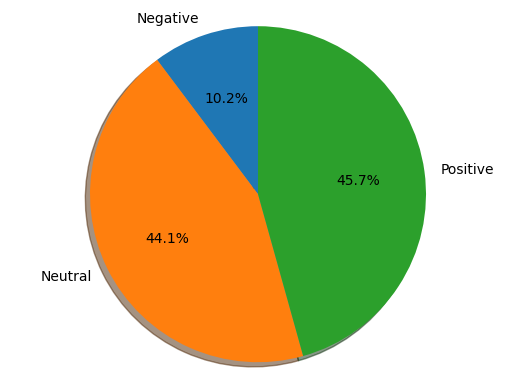

In [184]:
labels = ['Negative','Neutral','Positive']
listValues = list(sentimentcount.select('count').toPandas()['count'])
sum = 0
for item in listValues:
   sum += item
    
print(sum)
print(listValues)
listValues = [(number / sum)*100 for number in listValues]
print(listValues)
fig1, ax1 = plt.subplots()
ax1.pie(listValues, labels=labels ,autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

/opt/homebrew/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/homebrew/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/homebrew/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/homebrew/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

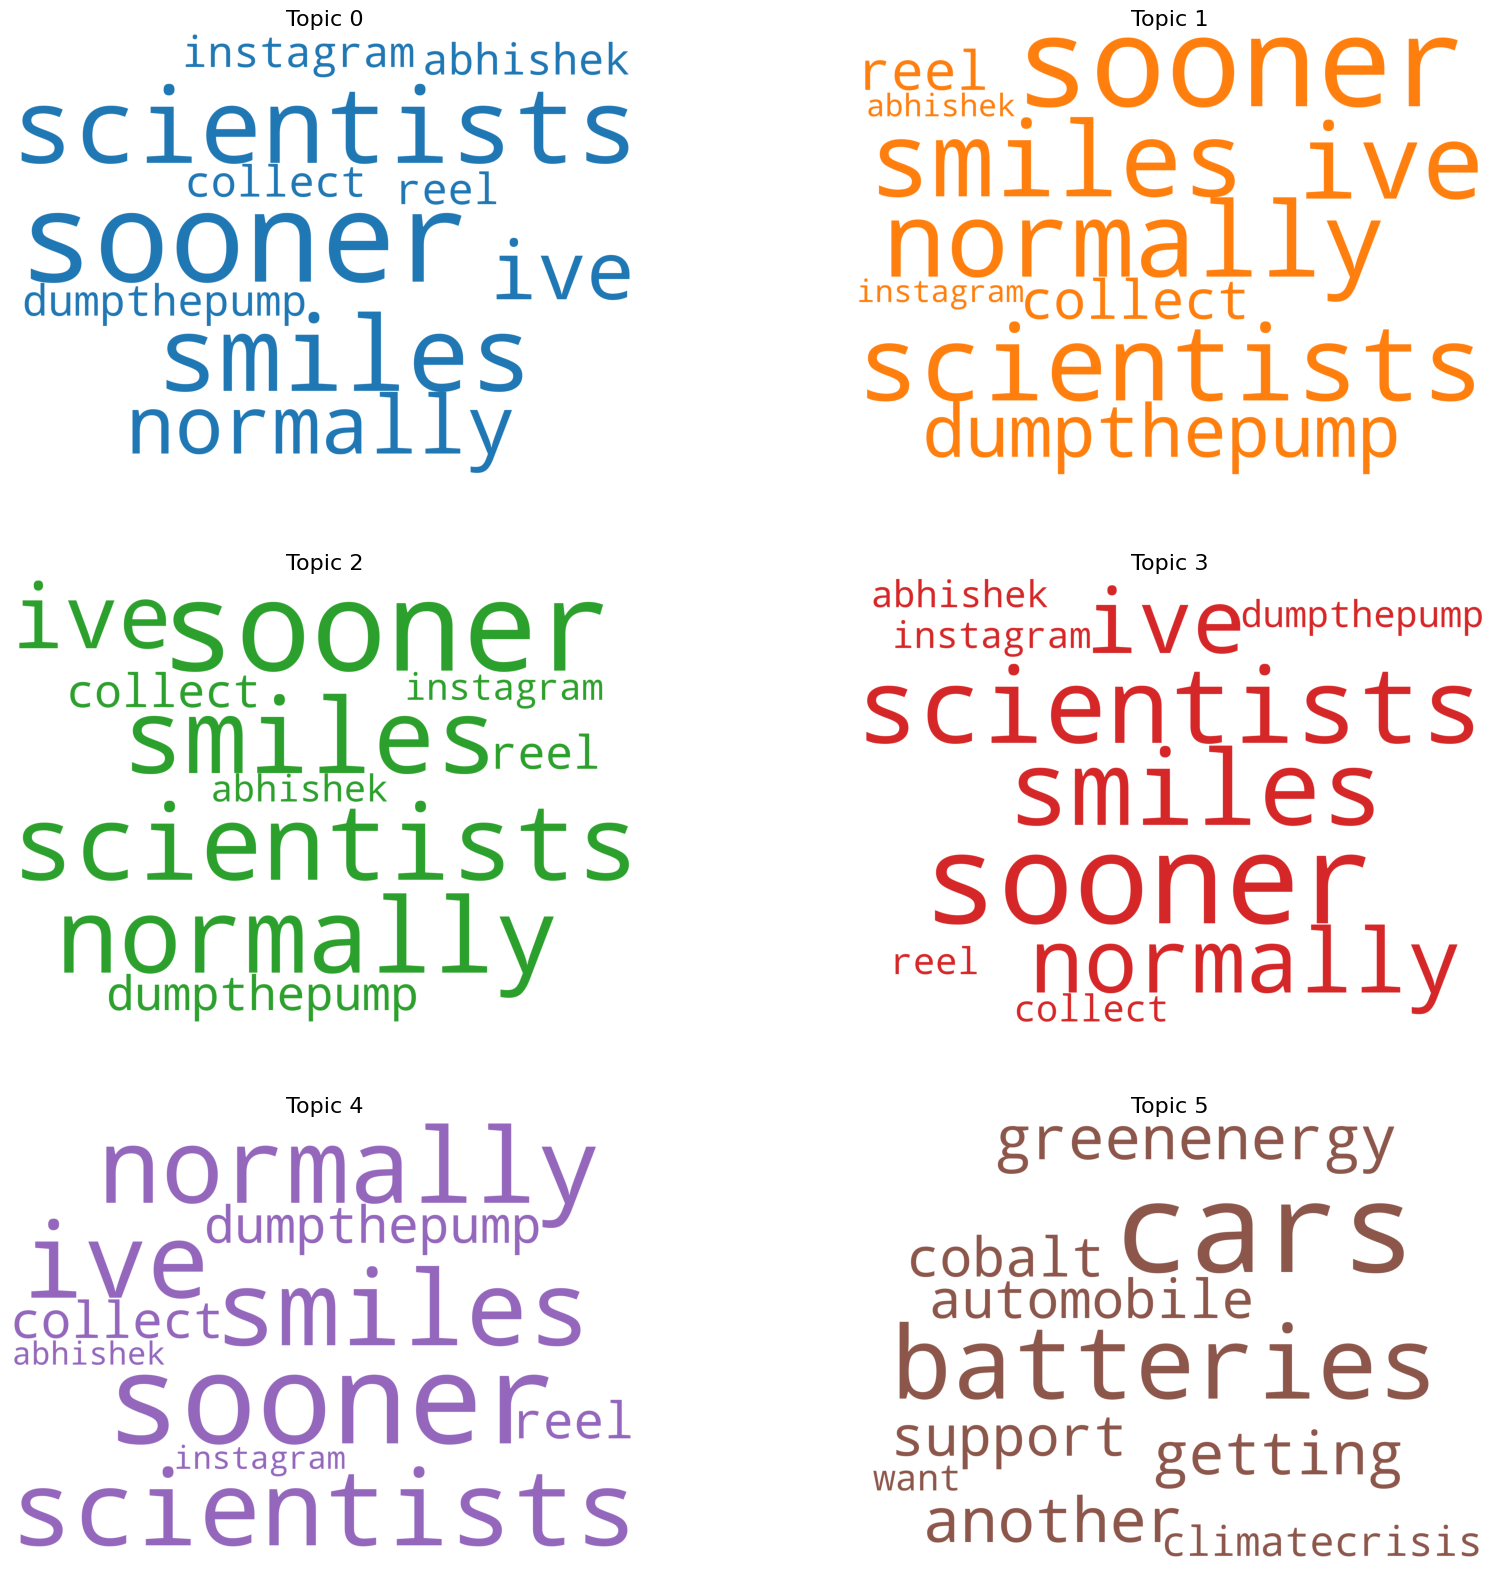

In [185]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwordList,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

In [186]:
data_lemmatized = filteredContents
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.340818934093606
